In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import matplotlib.pyplot as plt

In [39]:
class European_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.95, epsilon = 1e-2):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.epsilon = epsilon

    def d1(self):
        return (np.log(self.S0 / self.K) + (self.r + self.sigma ** 2 / 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def d2(self):
        return (np.log(self.S0 / self.K) + (self.r - self.sigma ** 2 / 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def Black_Sholes_Price(self):
        
        if self.option_type == "call":
            price = self.S0 * norm.cdf(self.d1()) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2())

        elif self.option_type == "put":
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) - self.S0 * norm.cdf(-self.d1())

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return price

    def Black_Sholes_Delta(self):

        if self.option_type == "call":
            delta = norm.cdf(self.d1())

        elif self.option_type == "put":
            delta = -norm.cdf(-self.d1())

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return delta

    def Black_Sholes_Gamma(self):

        if self.option_type == "call":
            gamma = norm.pdf(self.d1()) / (self.S0 * self.sigma * np.sqrt(self.T))

        elif self.option_type == "put":
            gamma = norm.pdf(self.d1()) / (self.S0 * self.sigma * np.sqrt(self.T))

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return gamma  

    def Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Antithetic_Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (int(self.sample_size / 2), 1))
        ST1 = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * (-G))
        
        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) + np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / 2 
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) + np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / 2 
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Importance_Sampling_Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        mu = (np.log(self.K / self.S0) - (self.r - self.sigma ** 2 / 2) * self.T) / self.sigma
        
        if self.option_type == "call":
            ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * (G + mu))
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * np.exp(-mu * G - mu ** 2 / 2)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * (G + mu))
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * np.exp(-mu * G - mu ** 2 / 2)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Bump_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        h = self.S0 * self.epsilon
        ST1 = (self.S0 + h) * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = (self.S0 - h) * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) - np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / (2 * h)
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) - np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / (2 * h)
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Bump_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        h = self.S0 * self.epsilon
        ST0 = (self.S0) * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST1 = (self.S0 + h) * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = (self.S0 - h) * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) - 2 * (np.exp(-self.r * self.T) * np.maximum(ST0 - self.K, 0)) + np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / (h ** 2)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) - 2 * (np.exp(-self.r * self.T) * np.maximum(self.K - ST0, 0)) + np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / (h ** 2)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Pathwise_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (ST > self.K) * ST / self.S0
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (self.K > ST) * (-ST) / self.S0
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Likelihood_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * G / (self.S0 * self.sigma * np.sqrt(self.T))
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * G / (self.S0 * self.sigma * np.sqrt(self.T))
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Likelihood_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * (((G**2 - 1) / ((self.S0**2) * (self.sigma**2) * self.T)) - (G / ((self.S0**2) * self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * (((G**2 - 1) / ((self.S0**2) * (self.sigma**2) * self.T)) - (G / ((self.S0**2) * self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Pathwise_Likelihood_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (ST / (self.S0**2)) * (ST > self.K) * ((G / (self.sigma * np.sqrt(self.T))) - 1)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (ST / (self.S0**2)) * (self.K > ST) * (1 - (G / (self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Likelihood_Pathwise_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (self.K / (self.S0**2)) * (ST > self.K) * (G / (self.sigma * np.sqrt(self.T)))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (-self.K / (self.S0**2)) * (self.K > ST) * (G / (self.sigma * np.sqrt(self.T)))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

In [43]:
european_option = European_Option(
    S0 = 100,               # Spot price of 100
    K = 60,                 # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

print(f"Black-Sholes Option price: {european_option.Black_Sholes_Price():.5f}")
print('\n')
mc_price, mc_confidence_interval, mc_error = european_option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")
print('\n')
antithetic_mc_price, antithetic_mc_confidence_interval, antithetic_mc_error = european_option.Antithetic_Monte_Carlo_Price()
print(f"Antithetic Monte Carlo Option Price: {antithetic_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Antithetic Confidence Interval: [{antithetic_mc_confidence_interval[0]:.5f}, {antithetic_mc_confidence_interval[1]:.5f}]")
print(f"Antithetic Monte Carlo Error: {antithetic_mc_error:.5f}")
print('\n')
importance_sampling_mc_price, importance_sampling_mc_confidence_interval, importance_sampling_mc_error = european_option.Importance_Sampling_Monte_Carlo_Price()
print(f"Importance Sampling Monte Carlo Option Price: {importance_sampling_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Importance Sampling Confidence Interval: [{importance_sampling_mc_confidence_interval[0]:.5f}, {importance_sampling_mc_confidence_interval[1]:.5f}]")
print(f"Importance Sampling Monte Carlo Error: {importance_sampling_mc_error:.5f}")

Black-Sholes Option price: 0.01129


Monte Carlo Option Price: 0.01250
95% Confidence Interval: [0.00712, 0.01789]
Monte Carlo Error: 0.00538


Antithetic Monte Carlo Option Price: 0.01030
95% Antithetic Confidence Interval: [0.00726, 0.01334]
Antithetic Monte Carlo Error: 0.00304


Importance Sampling Monte Carlo Option Price: 0.01144
95% Importance Sampling Confidence Interval: [0.01116, 0.01172]
Importance Sampling Monte Carlo Error: 0.00028


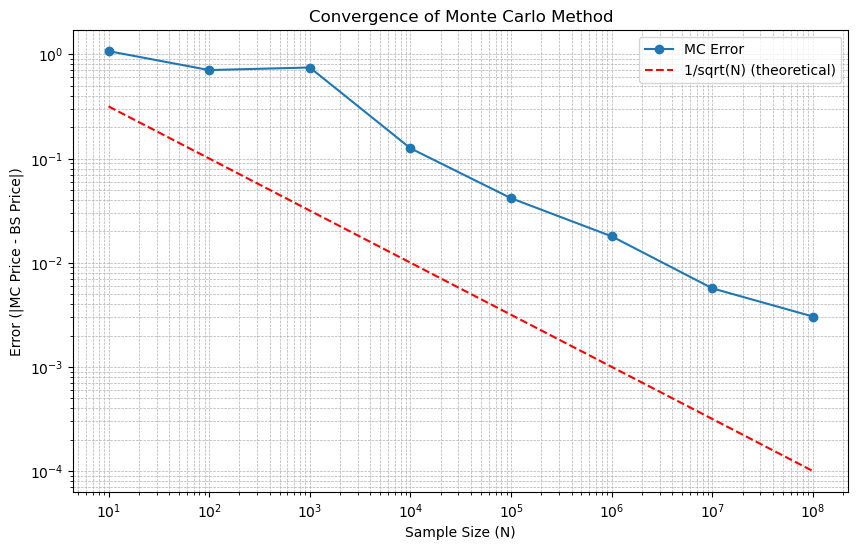

In [5]:
N = []
error = []
for ii in range(1, 9):
    option_test = European_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call",   # Option Type
    sample_size = 10**ii    # Sample Size
    )
    bs_price = option_test.Black_Sholes_Price()
    mc_price, _, _ = option_test.Monte_Carlo_Price()
    N.append(10**ii)
    error.append(np.abs(bs_price - mc_price))

theoretical_error = [1 / np.sqrt(n) for n in N]
plt.figure(figsize=(10, 6))
plt.loglog(N, error, marker='o', label="MC Error")
plt.loglog(N, theoretical_error, linestyle='--', color='red', label="1/sqrt(N) (theoretical)")
plt.xlabel("Sample Size (N)")
plt.ylabel("Error (|MC Price - BS Price|)")
plt.title("Convergence of Monte Carlo Method")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

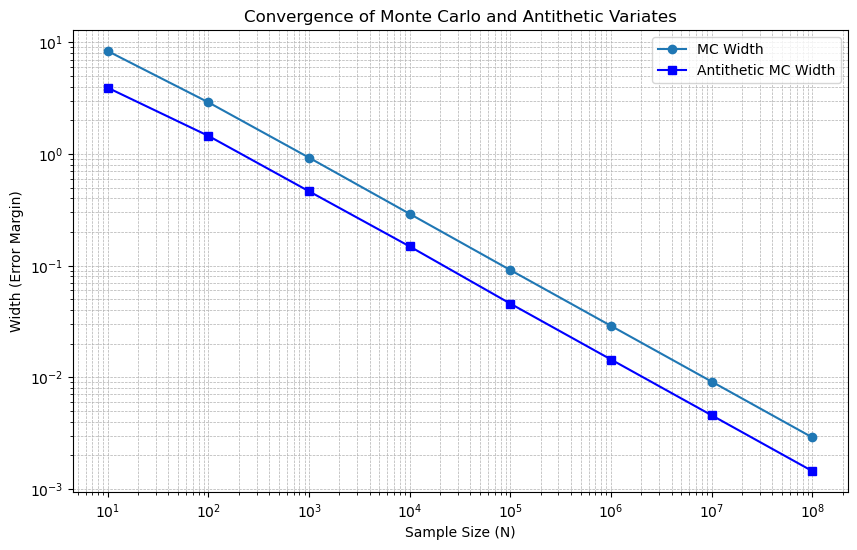

In [6]:
N = []
width = []
antithetic_width = []
for ii in range(1, 9):
    option_test = European_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call",   # Option Type
    sample_size = 10**ii    # Sample Size
    )
    _, _, error = option_test.Monte_Carlo_Price()
    _, _, antithetic_error = option_test.Antithetic_Monte_Carlo_Price()
    N.append(10**ii)
    width.append(error)
    antithetic_width.append(antithetic_error)

plt.figure(figsize=(10, 6))
plt.loglog(N, width, marker='o', label="MC Width")
plt.loglog(N, antithetic_width, marker='s', label="Antithetic MC Width", color='blue')
plt.xlabel("Sample Size (N)")
plt.ylabel("Width (Error Margin)")
plt.title("Convergence of Monte Carlo and Antithetic Variates")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [7]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
bump_delta, bump_delta_confidence_interval, bump_delta_error = european_option.Bump_Delta()
print(f"Monte Carlo Option Bump Delta: {bump_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{bump_delta_confidence_interval[0]:.5f}, {bump_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {bump_delta_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
bump_gamma, bump_gamma_confidence_interval, bump_gamma_error = european_option.Bump_Gamma()
print(f"Monte Carlo Option Bump Gamma: {bump_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{bump_gamma_confidence_interval[0]:.5f}, {bump_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {bump_gamma_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Bump Delta: 0.63532
95% Confidence Interval: [0.62412, 0.64652]
Monte Carlo Error: 0.01120


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Bump Gamma: 0.01880
95% Confidence Interval: [0.01668, 0.02093]
Monte Carlo Error: 0.00212


In [8]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
pathwise_delta, pathwise_delta_confidence_interval, pathwise_delta_error = european_option.Pathwise_Delta()
print(f"Monte Carlo Option Pathwise Delta: {pathwise_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{pathwise_delta_confidence_interval[0]:.5f}, {pathwise_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {pathwise_delta_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Pathwise Delta: 0.63802
95% Confidence Interval: [0.62676, 0.64927]
Monte Carlo Error: 0.01126


In [9]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
likelihood_delta, likelihood_delta_confidence_interval, likelihood_delta_error = european_option.Likelihood_Delta()
print(f"Monte Carlo Option Likelihood Delta: {likelihood_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_delta_confidence_interval[0]:.5f}, {likelihood_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_delta_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
likelihood_gamma, likelihood_gamma_confidence_interval, likelihood_gamma_error = european_option.Likelihood_Gamma()
print(f"Monte Carlo Option Likelihood Gamma: {likelihood_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_gamma_confidence_interval[0]:.5f}, {likelihood_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_gamma_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Likelihood Delta: 0.64240
95% Confidence Interval: [0.61305, 0.67174]
Monte Carlo Error: 0.02935


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Likelihood Gamma: 0.01798
95% Confidence Interval: [0.01520, 0.02076]
Monte Carlo Error: 0.00278


In [10]:
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
pathwise_likelihood_gamma, pathwise_likelihood_gamma_confidence_interval, pathwise_likelihood_gamma_error = european_option.Pathwise_Likelihood_Gamma()
print(f"Monte Carlo Option Pathwise-Likelihood Gamma: {pathwise_likelihood_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{pathwise_likelihood_gamma_confidence_interval[0]:.5f}, {pathwise_likelihood_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {pathwise_likelihood_gamma_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
likelihood_pathwise_gamma, likelihood_pathwise_gamma_confidence_interval, likelihood_pathwise_gamma_error = european_option.Likelihood_Pathwise_Gamma()
print(f"Monte Carlo Option Pathwise-Likelihood Gamma: {likelihood_pathwise_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_pathwise_gamma_confidence_interval[0]:.5f}, {likelihood_pathwise_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_pathwise_gamma_error:.5f}")

Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Pathwise-Likelihood Gamma: 0.01908
95% Confidence Interval: [0.01833, 0.01983]
Monte Carlo Error: 0.00075


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Pathwise-Likelihood Gamma: 0.01907
95% Confidence Interval: [0.01852, 0.01962]
Monte Carlo Error: 0.00055


In [11]:
class Brownian_Motion:
    def __init__(self, T, time_grid = 1000, sample_size = 5):
        self.T = T
        self.time_grid = time_grid
        self.sample_size = sample_size

    def Brownian_Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        increments = np.sqrt(self.T / self.time_grid) * G
        increments = np.cumsum(increments, axis = 1)
        path = np.concatenate((np.zeros((self.sample_size, 1)), increments), axis = 1)

        return path

    def Plot_Path(self):
        path = self.Brownian_Path()
        time_points = np.linspace(0, self.T, self.time_grid + 1)
        for i in range(self.sample_size):
            plt.plot(time_points, path[i], label = f'Path {i + 1}' if self.sample_size <= 5 else None)
        plt.title(f'Simulated Brownian Paths ({self.sample_size} paths)')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.grid(True)
        if self.sample_size <= 5:
            plt.legend()
        plt.show()

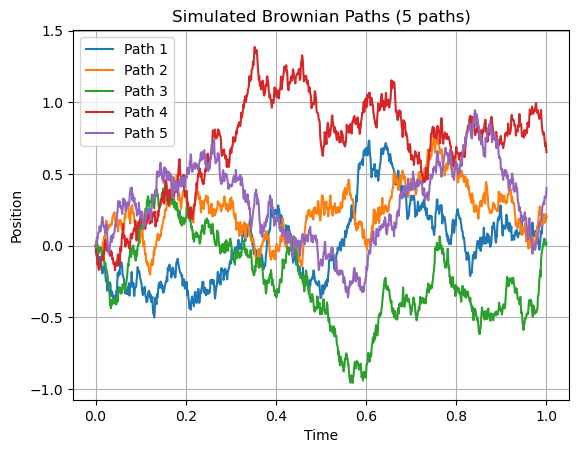

In [12]:
brownian_motion = Brownian_Motion(
    T = 1
)

brownian_motion.Plot_Path()

In [13]:
class Asian_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.{european_option.confidence_level * 100:.0f}, time_grid = 1000, integration_method = "Simpson"):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.time_grid = time_grid
        self.integration_method = integration_method

    def Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma ** 2) * (self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_increments = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_increments, axis = 1)
        path = np.exp(log_path)

        return path

    def Riemann_Integral(self):
        path = self.Path()
        integral = np.mean(path, axis = 1) 

        return integral

    def Trapezoidal_Integral(self):
        path = self.Path()
        integral = (self.T / self.time_grid) * (((path[:, 0] + path[:, -1]) / 2) + np.sum(path[:, 1:-1], axis = 1))

        return integral

    def Simpson_Integral(self):
        path = self.Path()
        integral = ((self.T / self.time_grid) / 3) * (path[:, 0] + 4 * np.sum(path[:, 1:-1:2], axis = 1) + 2 * np.sum(path[:, 2:-1:2], axis = 1) + path[:, -1])
        
        return integral

    def Monte_Carlo_Price(self):

        if self.option_type == "call":
            if self.integration_method == "Riemann":
                integral = self.Riemann_Integral()
            elif self.integration_method == "Trapezoid":
                integral = self.Trapezoid_Integral()
            elif self.integration_method == "Simpson":
                integral = self.Simpson_Integral()
            else:
                raise ValueError("Invalid Integration Method: it must be 'Riemann', 'Trapezoid' or 'Simpson'")
            
            payoff = np.exp(-self.r * self.T) * np.maximum(integral - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        elif self.option_type == "put":
            if self.integration_method == "Riemann":
                integral = self.Riemann_Integral()
            elif self.integration_method == "Trapezoid":
                integral = self.Trapezoid_Integral()
            elif self.integration_method == "Simpson":
                integral = self.Simpson_Integral()
            else:
                raise ValueError("Invalid Integration Method: it must be 'Riemann', 'Trapezoid' or 'Simpson'")
                
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - integral, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

SyntaxError: invalid decimal literal (4147391506.py, line 2)

In [ ]:
option = Asian_Option(
    S0 = 100,               # Spot price of 100
    K = 90,                 # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

mc_price, mc_confidence_interval, mc_error = option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")

In [ ]:
class Barrier_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, barrier, sample_size = 10000, confidence_level = 0.{european_option.confidence_level * 100:.0f}, time_grid = 1000):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.barrier = barrier
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.time_grid = time_grid

    def Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma ** 2) * (self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_increments = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_increments, axis = 1)
        path = np.exp(log_path)

        return path
        
    def Monte_Carlo_Price(self):
        path = self.Path()
        max_path = np.max(path, axis = 1)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(path[:, -1] - self.K, 0) * (max_path > self.barrier)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - path[:, -1], 0) * (max_path > self.barrier)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

In [ ]:
option = Barrier_Option(
    S0 = 100,               # Spot price of 100
    K = 90,                 # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call",   # Option Type
    barrier = 90            # Barrier
)

mc_price, mc_confidence_interval, mc_error = option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")